# DATA DOWNLOAD
 中文英文语句pair， 每一行是一个语句， 目标是分类 中文 和英文一共 2千万行
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw

https://www.kaggle.com/seesea0203/segmented-train-seg-by-word
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [1]:
! wc -l data/segmented_train_seg_by_word.txt # 语句前面加上 ”!“ 就可以执行 bash/shell scripts

 20000000 data/segmented_train_seg_by_word.txt


## first 4 lines of the file: "segmented_train_seg_by_word.txt"

a pair of red - crowned cranes have staked out their nesting territory

一对 丹顶鹤 正 监视 着 它们 的 筑巢 领地

a pair of crows had come to nest on our roof as if they had come for lhamo .

一对 乌鸦 飞 到 我们 屋顶 上 的 巢里 ， 它们 好像 专门 为拉木 而 来 的 。

# DATA PROCESS

In [3]:
from utils import ProgressBar
import numpy as np
import collections
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
%matplotlib inline

In [4]:
enline = None # elglish line
chline = None # chinese line

sentlength = 4

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000) # from "utils" python file
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue # 继续for loop,读下一行.每一句英语句子，接下来的一行就是对应的中文语句
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()] # 去掉句末的换行符，convert成lowcase, split成数组
        chlinesp = [i for i in chline.strip("\n").split()] # 去掉句末的换行符, split成数组
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength: # > 4 个词的句子 忽略掉
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break
        

 100.00 % [==================================================>] 10000000/10000000 	 used:47s eta:0 s

In [5]:
len(enlines),len(chlines)

(150904, 150904)

In [7]:
enlines[1], chlines[1] # enlines, chlines 数组里存的 中英文 是一一对应的

(['one', 'against', '500', '.'], ['一对', '五百', '诶', '。'])

In [12]:
chlines[1][0]

'一对'

In [13]:
words = []

for sent in chlines: # e.g. chlines[1]:  ['一对', '五百', '诶', '。']
    for word in sent: # e.g. chlines[1][0]:  '一对'
        words.append(word) # 把每一行的一句话里每一个单词都存入words数组
        
for sent in enlines:
    for word in sent:
        words.append(word)

In [14]:
from collections import Counter # Counter, most_common

In [15]:
Counter(words).most_common(15)

[('.', 69213),
 ('。', 64997),
 ('？', 18494),
 ('?', 18486),
 ('的', 15156),
 ('...', 15073),
 (',', 13814),
 ('，', 12598),
 ('the', 11865),
 ('我', 11374),
 ('！', 11165),
 ('!', 10976),
 ('i', 8885),
 ('你', 7707),
 ('了', 7633)]

In [16]:
def addchar(what2ind,ind2what,char): # what2ind: char -> index,  ind2what: index -> char
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char # 通过len(what2ind), 这样 就一直append 在ind2what 数组后面下一个空位
    what2ind[char] = len(what2ind)

In [19]:
word2ind = {} # dict type
ind2word = {}

specialchars = ['<pad>','<unk>']

for specialchar in specialchars:
    addchar(word2ind,ind2word,specialchar)
    
print("word2ind", word2ind)
print("ind2word", ind2word)

word2ind {'<pad>': 0, '<unk>': 1}
ind2word {0: '<pad>', 1: '<unk>'}


In [20]:
for word,_ in Counter(words).most_common(10000): # 只处理频率高的 前10000的word. most_common: return {workd -> frequency}
    addchar(word2ind,ind2word,word)

In [37]:
dat_x_in = []
dat_y = []

for chsent,ensent in zip(chlines,enlines): # chlines数组：包含所有中文句子，enlines数组： 包含所有英语句子
    indsent = [word2ind.get(i,word2ind['<unk>']) for i in chsent] # 中文句子里每个单词转化为,word2ind字典里预先定义好的index i.e. indsent
    dat_x_in.append(indsent) # dat_x_in数组里，每个元素是一句话，用word2ind里index表示的一句话
    dat_y.append(0) # 0表示中文
    
    indsent = [word2ind.get(i,word2ind['<unk>']) for i in ensent]
    dat_x_in.append(indsent)
    dat_y.append(1) # 1表示英文

In [39]:
dat_x_in[0]

[1, 1, 3]

### 上面for loop解释
dat_x_in[1], dat_y[1] 

输出： ([1, 10, 5685, 2], 1)

ind2word.get(dat_x_in[1][0]), ind2word.get(dat_x_in[1][1]), ind2word.get(dat_x_in[1][2]), ind2word.get(dat_x_in[1[3])

输出： ('<unk>', 'the', 'winner', '.')

In [40]:
# 运行下面一句之前： dat_x_in[0] -> [1, 1, 3] 运行下面一句之后： dat_x_in[0] -> [1, 1, 3, 0]
# 作用就是长度不够4的，在句子结尾padding，不上特殊字符<pad>对应的index
# keras pad_sequence是如何知道要padding 到长度为4的？ 因为由于前面处理的时候，最长的句子也就是4，所以 都会padding 成长度为4的
# padding='post' 表示在句子后面补
dat_x_in = tf.keras.preprocessing.sequence.pad_sequences(dat_x_in,padding='post',value=word2ind['<pad>'])

In [42]:
type(dat_x_in) # 上面keras padding方法也顺便把 python native 数组 convert 成了numpy ndarray类型了

numpy.ndarray

In [43]:
dat_y = np.asarray(dat_y)

In [44]:
dat_x_in.shape,dat_y.shape  # python native 数组没有.shape属性，只有np.ndarray才有

((301808, 4), (301808,))

In [45]:
def data_generator(batch_size):
    while True:
        for i in range(0,len(dat_x_in),batch_size): # batch_size相当于步长，每隔多少
            if i + batch_size < len(dat_x_in):
                yield dat_x_in[i:i + batch_size],dat_y[i:i + batch_size] #  不包含 i + batch_size， 由于步长为batch_size， 下一次从i + batch_size位置开始

In [46]:
gen = data_generator(256)

In [47]:
batch_x,batch_y = gen.__next__()

In [48]:
batch_x.shape ,batch_y.shape

((256, 4), (256,))

# MODEL PART

In [49]:
batch_size = 256
embedding_size = 100 # 就是词的embedding表的列数， 也就是每个单词就会变成 1 * 100 的矩阵
vocabulary_size = len(ind2word)
num_units = 50 # 表示一共多少RNN cell. hyper parameter

In [51]:
import tensorflow as tf
#import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


In [52]:
with tf.device('/gpu:1'):
    initializer = tf.random_uniform_initializer(-0.08, 0.08) # 所有变量都 在这个范围内的 均匀分布
    tf.get_variable_scope().set_initializer(initializer)
    x = tf.placeholder("int32", [None, None]) # 
    y = tf.placeholder("int32", [None])
    x_len = tf.placeholder("int32",[None]) # 句子在没有被padding 之前的实际长度. 这个 batch 里每个句子要过多少个RNN cell. rnn里 sequence_length
    
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding
    # vocabulary_size = len(ind2word), embedding_size=100 [vocabulary_size, embedding_size] 就是 n * 100的embedding词表
    # tf.get_variable("embedding_encoder") 就是获得指定名称，指定大小的变量而已
    embedding_encoder = tf.get_variable("embedding_encoder", [vocabulary_size, embedding_size],dtype=tf.float32)
    encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, x) # embedding就是查表的过程，encoder_emb_inp将会作为RNN cell的 input
    
    # Build RNN cell
    encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units) # 表示一共多少RNN cell
    
    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    # encoder_outputs PPT里每个输出y1, y2..
    # encoder_state 就是最后一个RNN cell的输出state
    # x_len 表示是实际的句子的长度（没有被padding之前的原始长度），这样RNN 模型就知道用几个RNN cell,也就是知道需要哪个RNN cell时间片的输出
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
    
    # 因为用了LSTM, 所以encoder_state输出是数组，有多个hidden state, 所以encoder_state[0]表示用上面的输出 如果使用basic RNN 就用encoder_state就好了
    # 把sequence最后一个RNN cell输出的state,送入到FC layer. 
    # before FC layer, encoder_state[0] -> 256 * 50, after FC layer, -> 256 * 1  (1表示维度。。因为就是2分类)
    model_logistic = tf.layers.dense(encoder_state[0],1) 
    model_pred = tf.nn.sigmoid(model_logistic)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y,tf.float32),logits=tf.reshape(model_logistic,(-1,)))
    loss = tf.reduce_mean(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [53]:
session.run(tf.global_variables_initializer())

In [54]:
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size)
for one_epoch in range(0,1): # 就run一个epoch
    pb = ProgressBar(worksum=len(dat_x_in))
    pb.startjob()
    for one_batch in range(0,len(dat_x_in),batch_size):
        batch_x,batch_y = gen.__next__()
        batch_x_len = np.asarray([len(i) for i in batch_x]) # 每一个batch里，每一个sample句子长度构成的数组
        batch_lr = beginning_lr 
        
        # 怎么决定要传入哪些参数给 feed_dict? 一般placehold 类型的要传入
        _,batch_loss = session.run([optimizer,loss],feed_dict={
            x:batch_x,
            y:batch_y,
            x_len:batch_x_len,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size) # 没finish training一个batch,  打印一次进度条
        losses.append(batch_loss)

EPOCH 0 batch 301568 lr 0.1 loss 0.1441277414560318 100.01 % [==================================================>] 301824/301808 	 used:5s eta:0 sss

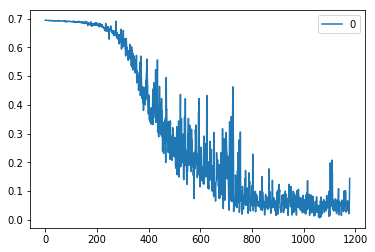

In [55]:
%matplotlib inline
pd.DataFrame(losses).plot()

# run predict

In [59]:
def predict_result(sent):
    senttoken = [word2ind[i.lower()] for i in sent.split()] # 输入的句子:1. 按空格分割 2.每个单词变成lowercase 3. convert成index
    inputx = np.asarray([senttoken]) # Python的native array 变成 np.array
    inputx_len = np.asarray([len(senttoken)])
    
    print(inputx,inputx_len)
    """
        model_logistic = tf.layers.dense(encoder_state[0],1) # FC layer
        model_pred = tf.nn.sigmoid(model_logistic)
    """
    
    batch_predict = session.run(model_pred,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return "英文" if batch_predict > 0.5 else "中文"

In [60]:
source_sentence = "who are you , what do you want ."

In [61]:
predict_result(source_sentence)

[[278  48  18   8  29 125  18 186   2]] [9]


'英文'